tHIS METHOD SEEMS TO BE INTENDED FOR RAW TRACES?

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import networkx as nx
import sys
import os
import pandas as pd
import frites
#https://github.com/brainets/frites
#pip install -U frites

import xarray as xr
from frites.estimator import (GCMIEstimator, CorrEstimator, DcorrEstimator)
from frites.conn import conn_dfc, define_windows
from frites import set_mpl_style

from typing import Tuple

from sklearn.cluster import DBSCAN

sys.path.append("..")
from analysis_package import maxlab_analysis as mla

In [3]:
file_path = "data/"
file_name = "div21.data.raw.h5"
well_no = 0
recording_no = 0

In [4]:
def load_data(
    path: str,
    well_no: int,
    recording_no: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    spikes = mla.load_spikes_from_file(path, well_no, recording_no)
    mapping = mla.load_mapping(path, well_no, recording_no)

    # for i in spikes.index:
    #     if spikes.loc[i, "channel"] not in mapping["channel"]:
    #         spikes.drop(i)
    spikes = spikes.loc[spikes["channel"].isin(mapping["channel"]), :]
    return spikes, mapping


spike_pd_df, mapping_pd_df = load_data(file_path + file_name,
                                        well_no,
                                        recording_no,)

display(spike_pd_df)
display(mapping_pd_df)

,time,channel,amplitude
0,-0.09920,988,-5.297205
1,-0.09920,993,-3.777930
2,-0.09920,709,-8.748223
3,-0.09920,841,-9.860536
4,-0.09915,937,-9.435249
...,...,...,...
1185766,299.91070,267,-5.682082
1185767,299.91070,463,-12.697094
1185768,299.91075,211,-6.560393
1185769,299.91310,815,-10.938105


,channel,electrode,x,y
0,0,20290,875.0,1610.0
1,1,16436,2730.0,1295.0
2,2,15900,1050.0,1260.0
3,3,16878,2765.0,1330.0
4,4,16774,945.0,1330.0
...,...,...,...,...
857,1019,22131,2292.5,1750.0
858,1020,11100,1750.0,875.0
859,1021,6728,2240.0,525.0
860,1022,21635,1312.5,1715.0


862
862
[17  2 13 23 10  0  1  2  3 11  4 23  5  6  7  8  9  2 10 11 84  2 31 23
 12 11 10  2 13 11 36 14 36 15 16 14 16 11 10 28 29 14 17  8 48 18 16 18
 16  0  3 34 20 14 46 28 16 19 29 47  4  8 16 18 20  8 21 11 20  0 74 11
 29 22  5 23 71 38 17  6 21 14  4 34 29  6 24  0  4 25 17 27  1 26  3 28
  3  6 12  0  4 27 13 47  5 14  3 91 22 21 28 21 14 13  8  9 47 13 27 29
 30 56 14 31 25 32  2 33 32 34 33 32 18  3 19 32 72 95 26 89 27 21 35 21
 33 46 25 36 27 13 26 32 43 37 38 62  1 19 36 15 13 30 32 11  3 19 13 33
 12 15 29 39  5 22 37 47  6 10 35 12 22 40  0 31 26  3 41 45 26 36 23 37
 18 42 43 26 40 27 44  8 13 18 45  8 36 44  8 36 43 31  8 31 34 45  0 10
 18 42 23 21 15 31 18 40 43 31  0 10 41  9 19 17 27  9 33 45 43 17 69 84
 72 30 12 43 16 46 43 46 38 12 34 46 32 56 47 58 40 50 40 35 50 48 49 56
 48 49 21 50 48 49 56 75 48 50 40 80 51 53 51 52 44 53 10 43 31  6 96  2
 19 96  2 38 91 35 54 61  0 33 49 27 55 56 57 20 19 58 59  6 60 27 18 74
 41  4 26 61 59 29 14 48 11  7 62  2 21  7 

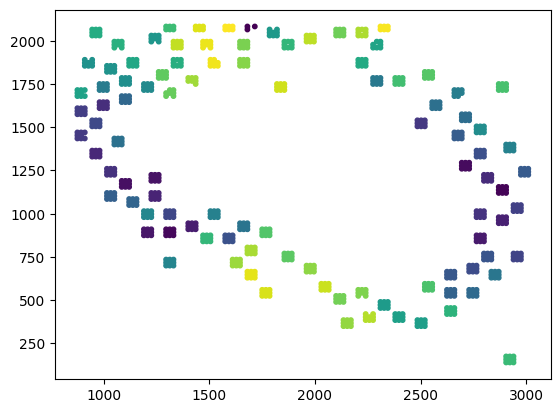

In [5]:
#Cluster points
#17.5 x sqrt(2) = 24.8
clustering = DBSCAN(eps = 25).fit(mapping_pd_df.loc[:, ["x", "y"]])
labels = clustering.labels_
mapping_pd_df["label"] = labels

print(len(mapping_pd_df))
print(len(labels))
print(labels)
print(max(labels))
print(len(mapping_pd_df.loc[:, "x"]))
plt.scatter(mapping_pd_df.loc[:, "x"], mapping_pd_df.loc[:, "y"],  s = 10, c = labels)
plt.show()


In [6]:
clustering_dict = dict()
for i, chan in enumerate(mapping_pd_df["channel"]):
    clustering_dict[chan] = labels[i]
clustering_dict
print(max(clustering_dict.values()))

98


In [7]:
mapping_pd_df_channel_replaced = mapping_pd_df.drop(["channel"], axis = 1).rename(columns = {"label": "channel"})
mapping_pd_df_channel_replaced = mapping_pd_df_channel_replaced.groupby("channel").mean().reset_index()
#mapping_pd_df_channel_replaced.set_index("channel", inplace=True)
display(mapping_pd_df_channel_replaced)
spike_pd_df_channel_replaced = spike_pd_df.copy()
spike_pd_df_channel_replaced["original channel"] = spike_pd_df_channel_replaced["channel"]
spike_pd_df_channel_replaced["channel"] = spike_pd_df_channel_replaced["channel"].replace(clustering_dict)

display(spike_pd_df_channel_replaced)
spike_pd_df_channel_replaced.drop_duplicates(inplace = True, subset = ["time", "channel"])
spike_pd_df_channel_replaced = spike_pd_df_channel_replaced.reset_index(drop = True)
display(spike_pd_df_channel_replaced)

print(max(spike_pd_df_channel_replaced["channel"]))


,channel,electrode,x,y
0,-1,26203.333333,1691.666667,2076.666667
1,0,14465.000000,2887.500000,1137.500000
2,1,11295.000000,1312.500000,892.500000
3,2,16215.000000,2712.500000,1277.500000
4,3,14803.000000,1102.500000,1172.500000
...,...,...,...,...
95,94,8237.000000,1697.500000,647.500000
96,95,24972.500000,1487.500000,1979.687500
97,96,23599.375000,1520.312500,1870.312500
98,97,26203.000000,2327.500000,2073.750000


,time,channel,amplitude,original channel
0,-0.09920,82,-5.297205,988
1,-0.09920,82,-3.777930,993
2,-0.09920,82,-8.748223,709
3,-0.09920,82,-9.860536,841
4,-0.09915,82,-9.435249,937
...,...,...,...,...
1185766,299.91070,43,-5.682082,267
1185767,299.91070,43,-12.697094,463
1185768,299.91075,43,-6.560393,211
1185769,299.91310,39,-10.938105,815


,time,channel,amplitude,original channel
0,-0.09920,82,-5.297205,988
1,-0.09915,82,-9.435249,937
2,-0.09905,82,-13.193364,981
3,-0.09900,22,-8.859291,197
4,-0.09900,16,-13.904939,56
...,...,...,...,...
611843,299.90990,5,-17.184206,12
611844,299.91065,43,-9.491546,275
611845,299.91070,43,-17.420622,255
611846,299.91075,43,-6.560393,211


98


[-0.0992 -0.099  -0.0989 -0.0955]
(611848,)
[82 82 82 ... 43 43 39]
(611848,)


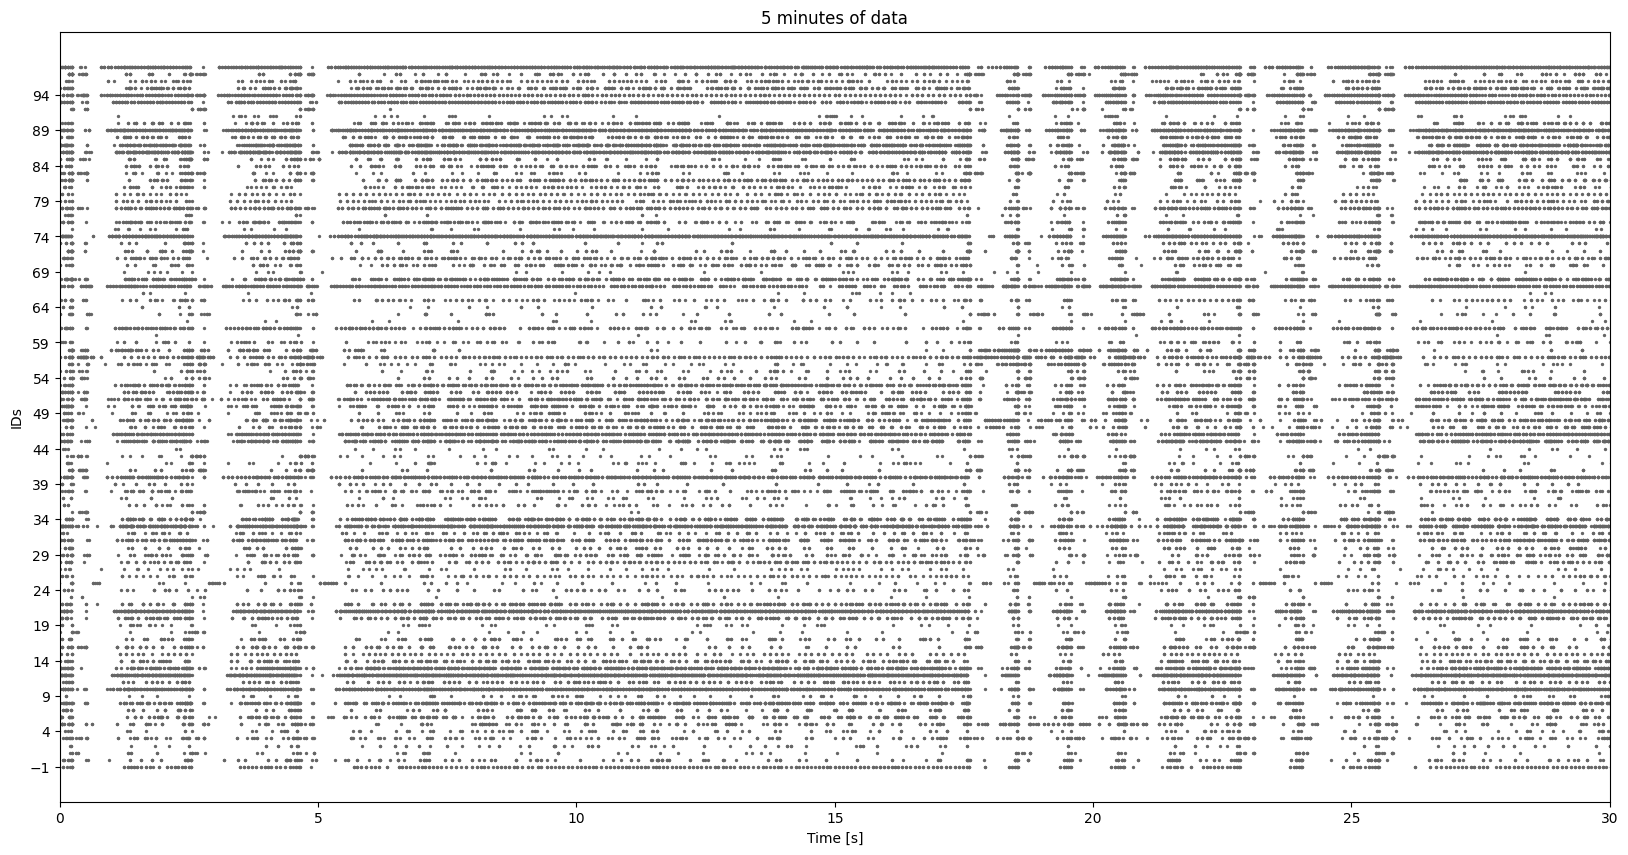

In [8]:
times = spike_pd_df_channel_replaced["time"].values
ids = spike_pd_df_channel_replaced["channel"].values
print(times[0:20:5])
print(np.shape(times))
print(ids)
print(np.shape(ids))

plt.figure(figsize = (20, 10))
plt.scatter(times, ids, s=2, c=[[.4,.4,.4]])
plt.yticks(np.unique(ids)[::5])
plt.xlim([0,30])
#plt.xticks([0,15,30])
plt.ylabel('IDs')
plt.xlabel('Time [s]')
plt.title('5 minutes of data')
plt.show()

In [9]:
binned_data = mla.bin_spike_data(spike_pd_df_channel_replaced, mapping_pd_df_channel_replaced, 0.001)

In [10]:
bins = binned_data[0]
annotated_spikes = binned_data[1]
times = binned_data[2]

In [11]:
print(np.array(bins.values).shape)

MemoryError: Unable to allocate 114. MiB for an array with shape (300014, 100) and data type int32

In [11]:
x = xr.DataArray(np.array([np.array(bins.values).T]).astype('float64'), dims=('trials', 'channels', 'times'),
                 coords=([0], bins.columns, times))
x

<xarray.DataArray (trials: 1, channels: 100, times: 300014)> Size: 240MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * trials    (trials) int32 4B 0
  * channels  (channels) int64 800B -1 0 1 2 3 4 5 6 ... 91 92 93 94 95 96 97 98
  * times     (times) float64 2MB -0.1 -0.099 -0.098 ... 299.9 299.9 299.9

In [12]:
dfc = conn_dfc(x, times='times', roi='channels')

print(np.dfc)

Defining links (n_roi=100; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 4950 pairs (gcrn=False)
C:\Users\mrwun\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Estimating DFC : 4950/4950 [00:35<00:00,  141.07it/s]

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (
                                                                        trials: 1,
                                                                        roi: 4950,
                                                                        times: 1)> Size: 40kB
array([[[4.98803456e-05],
        [6.52945928e-08],
        [3.06757283e-05],
        ...,
        [2.50362700e-05],
        [1.29029695e-05],
        [6.49015101e-06]]])
Coordinates:
  * trials   (trials) int32 4B 0
  * roi      (roi) <U5 99kB '-1-0' '-1-1' '-1-2' ... '96-97' '96-98' '97-98'
  * times    (times) float64 8B 149.9
Attributes:
    win_sample:  [     0 300013]
    win_times:   [149.9065]
    agg_ch:      0
    type:        dfc
    estimator:   Gaussian Copula Mutual Information Estimator
    unit:        Bits
    sfreq:       999.9999999999991
    sources:     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
    targets:     [1, 2

In [19]:
values = np.array(dfc[0, :, 0])

In [20]:
values

array([4.98803456e-05, 6.52945928e-08, 3.06757283e-05, ...,
       2.50362700e-05, 1.29029695e-05, 6.49015101e-06])

In [1]:
slwin_len = 20   # windows of length 500ms
slwin_step = 1  # 20ms step between each window (or 480ms overlap)

# define the sliding windows
sl_win = define_windows(times, slwin_len=slwin_len, slwin_step=slwin_step)[0]
print(sl_win)

# compute the DFC on sliding windows
dfc = conn_dfc(x, times='times', roi='channels', win_sample=sl_win)

# takes the mean over trials
dfc_m = dfc.mean('trials').squeeze()

# plot the mean over trials
dfc_m.plot.line(x='times', hue='roi')
plt.title(dfc.name), plt.ylabel('DFC')
plt.show()

NameError: name 'define_windows' is not defined